<a href="https://colab.research.google.com/github/MamadouBousso/IAProjects/blob/master/Simple_linear_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [12]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [13]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

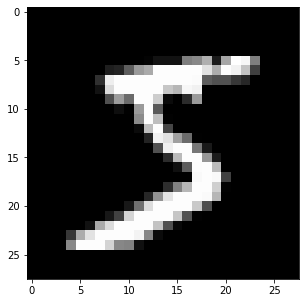

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder



Nous allons entraîner un encodeur automatique avec ces images en les aplatissant en des vecteurs de longueur 784. Les images de cet ensemble de données sont déjà normalisées de telle sorte que les valeurs soient comprises entre 0 et 1. Commençons par construire un simple auto-encodeur. L'encodeur et le décodeur doivent être constitués d'une **couche linéaire**. Les unités qui relient l'encodeur et le décodeur seront la _représentation compressée_.

Étant donné que les images sont normalisées entre 0 et 1, nous devons utiliser une **activation sigmoïde sur la couche de sortie** pour obtenir des valeurs qui correspondent à cette plage de valeurs d'entrée.


<img src='notebook_ims/simple_autoencoder.png' width=50% />




#### A FAIRE : Construisez le graphique de l'encodeur automatique dans la cellule ci-dessous.
> Les images d'entrée seront aplaties en des vecteurs de longueur 784. Les cibles sont les mêmes que les entrées.
> L'encodeur et le décodeur seront constitués de deux couches linéaires, chacune.
> Les dimensions de profondeur doivent changer comme suit : 784 entrées > **encoding_dim** > 784 sorties.
> Toutes les couches auront des activations ReLu appliquées à l'exception de la couche de sortie finale, qui a une activation sigmoïde.

**La représentation compressée doit être un vecteur de dimension `encoding_dim=32`.**

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.lin1 = nn.Linear(784,encoding_dim)
        ## decoder ##
        self.lin2 = nn.Linear(encoding_dim,784)
        

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        x = self.lin1(x)
        x = F.relu(x)
        x = torch.sigmoid(self.lin2(x))

        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (lin1): Linear(in_features=784, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
Ici, je vais écrire un peu de code pour entraîner le réseau. Je ne suis pas trop intéressé par la validation ici, donc je surveillerai simplement le training loss et le test loss par la suite.

Nous ne sommes pas concernés par les labels dans ce cas, juste les images, que nous pouvons obtenir à partir du `train_loader`. Étant donné que nous comparons les valeurs de pixels dans les images d'entrée et de sortie, il sera préférable d'utiliser une perte destinée qui a un sens pour une tâche de régression. La régression consiste à comparer des _quantités_ plutôt que des valeurs probabilistes. Donc, dans ce cas, j'utiliserai `MSELoss`. Et comparez les images de sortie et les images d'entrée comme suit :
```
loss = criterion(outputs, images)
```



In [27]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.600887
Epoch: 2 	Training Loss: 0.273446
Epoch: 3 	Training Loss: 0.239214
Epoch: 4 	Training Loss: 0.231943
Epoch: 5 	Training Loss: 0.228690
Epoch: 6 	Training Loss: 0.226660
Epoch: 7 	Training Loss: 0.225174
Epoch: 8 	Training Loss: 0.224023
Epoch: 9 	Training Loss: 0.223163
Epoch: 10 	Training Loss: 0.222440
Epoch: 11 	Training Loss: 0.221599
Epoch: 12 	Training Loss: 0.220978
Epoch: 13 	Training Loss: 0.220479
Epoch: 14 	Training Loss: 0.220023
Epoch: 15 	Training Loss: 0.219603
Epoch: 16 	Training Loss: 0.219202
Epoch: 17 	Training Loss: 0.218845
Epoch: 18 	Training Loss: 0.218515
Epoch: 19 	Training Loss: 0.218207
Epoch: 20 	Training Loss: 0.217914
Epoch: 21 	Training Loss: 0.217639
Epoch: 22 	Training Loss: 0.217379
Epoch: 23 	Training Loss: 0.217120
Epoch: 24 	Training Loss: 0.216868
Epoch: 25 	Training Loss: 0.216633
Epoch: 26 	Training Loss: 0.216413
Epoch: 27 	Training Loss: 0.216201
Epoch: 28 	Training Loss: 0.215995
Epoch: 29 	Training Loss: 0.2

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

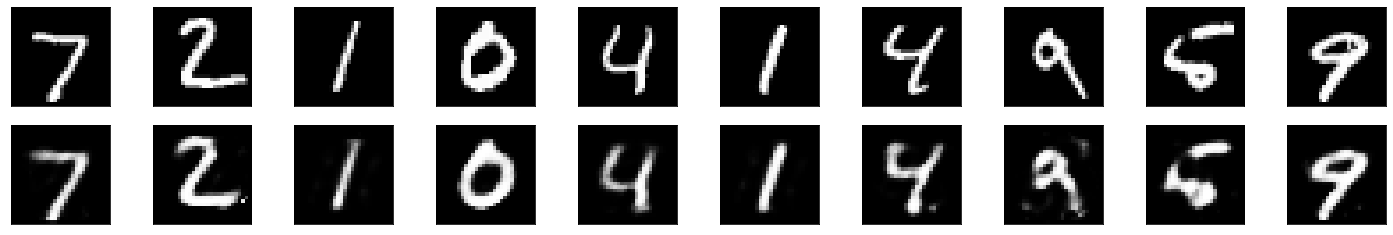

In [29]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.